/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/18.6M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/1.23M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/120000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/7600 [00:00<?, ? examples/s]

Map:   0%|          | 0/120000 [00:00<?, ? examples/s]

Map:   0%|          | 0/7600 [00:00<?, ? examples/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


✅ Baseline: time=321.7s acc=0.9307
[mc-learn-full step 50] |K|=41 N=17 q∈[0.12,0.12] ESS=40.9 ρ=0.01 loss=1.3801 (3.3s/50steps, 15.17steps/s)
[mc-learn-full step 100] |K|=46 N=17 q∈[0.12,0.12] ESS=45.9 ρ=0.01 loss=1.3672 (2.9s/50steps, 17.22steps/s)
[mc-learn-full step 150] |K|=46 N=17 q∈[0.23,0.24] ESS=45.8 ρ=0.01 loss=1.0682 (2.5s/50steps, 20.24steps/s)
[mc-learn-full step 200] |K|=39 N=17 q∈[0.33,0.33] ESS=38.9 ρ=0.01 loss=0.0858 (3.0s/50steps, 16.66steps/s)
[mc-learn-full step 250] |K|=37 N=17 q∈[0.33,0.33] ESS=36.9 ρ=0.01 loss=0.2998 (2.9s/50steps, 17.19steps/s)
[mc-learn-full step 300] |K|=43 N=17 q∈[0.20,0.21] ESS=42.9 ρ=0.01 loss=0.6089 (3.1s/50steps, 16.08steps/s)
[mc-learn-full step 350] |K|=39 N=17 q∈[0.12,0.12] ESS=38.9 ρ=0.01 loss=-0.1429 (2.6s/50steps, 19.44steps/s)
[mc-learn-full step 400] |K|=40 N=17 q∈[0.12,0.12] ESS=39.9 ρ=0.01 loss=0.8223 (2.4s/50steps, 20.63steps/s)
[mc-learn-full step 450] |K|=37 N=17 q∈[0.12,0.12] ESS=36.9 ρ=0.01 loss=-0.9067 (2.4s/50steps, 20.46s

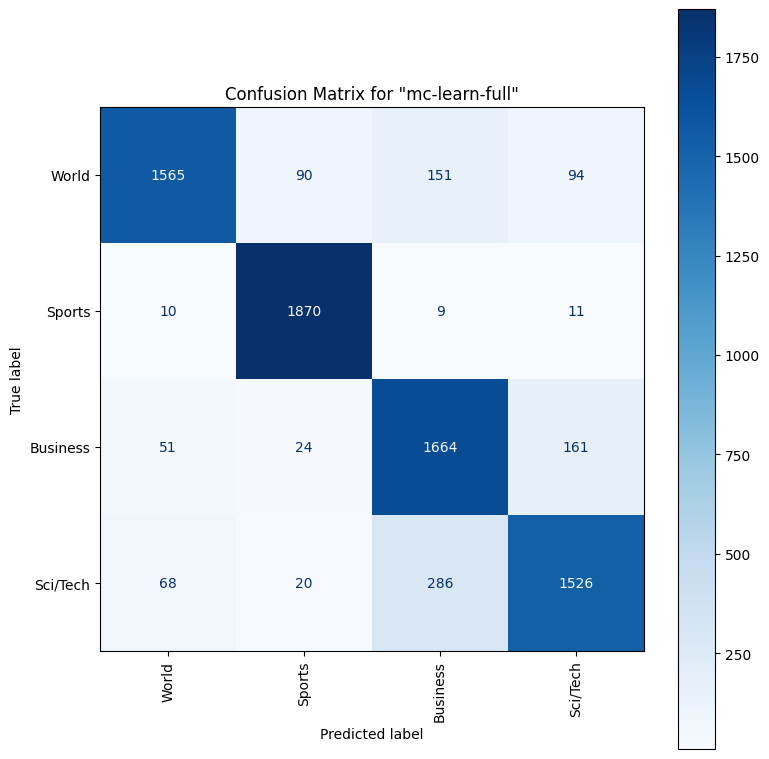

 -> Look for off-diagonal cells with high numbers. This shows which classes the model confuses.

Analyzing score distributions...


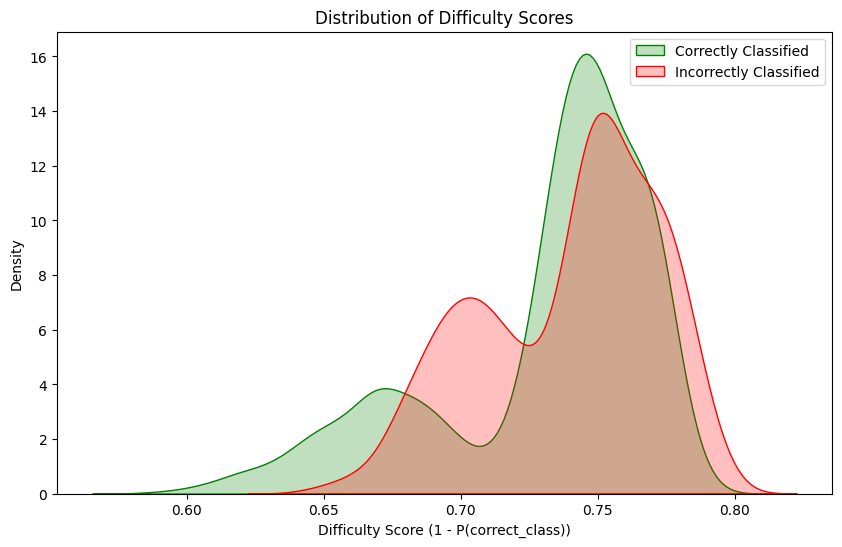

 -> THE SMOKING GUN: Look for a large red area at LOW scores.
 -> This means the scorer thinks an example is easy, but the model gets it wrong.

 FINAL REPORT 
Run                |     Acc |  Time(s) |  Speedup
--------------------------------------------------
Baseline           |  0.9307 |    321.7 |    1.00x
MC-Learn           |  0.8688 |    108.5 |    2.96x


In [1]:
# Monte Carlo Learn

import math, time, random, copy
from dataclasses import dataclass, field, replace
from typing import Dict, List, Tuple
from collections import deque, defaultdict
from contextlib import nullcontext

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.amp import GradScaler
from transformers import AutoTokenizer, AutoModelForSequenceClassification, get_cosine_schedule_with_warmup
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
try:
    from datasets import load_dataset
    HAS_DATASETS = True
except:
    HAS_DATASETS = False

# ----------------------------
# Configuration
# ----------------------------
@dataclass
class Cfg:
    run_name: str = "mc-learn-full"
    model_name: str = "distilbert-base-uncased"; num_labels: int = 4
    epochs: int = 1; batch_target: int = 64
    lr: float = 2e-5; lr_encoder_mult: float = 0.8; weight_decay: float = 0.01
    warmup_ratio: float = 0.1; grad_clip: float = 1.0; label_smoothing: float = 0.05
    device: str = "cuda" if torch.cuda.is_available() else "cpu"; use_amp: bool = True
    amp_dtype: str = "fp16"  # "fp16" | "bf16"

    # ----- MC-Learn knobs (Performance Tuned) -----
    score_len: int = 64
    score_exit_layer: int = 1
    replay_max: int = 4096; rho_init: float = 0.10
    tau_init: float = 1.0
    budget_ratio: float = 0.55
    refresh_N_init: int = 16
    refresh_N_range: Tuple[int,int] = (8, 32)
    q_bounds: Tuple[float,float] = (0.12, 0.33)
    kappa_schedule: Tuple[float,float,float] = (0.6, 0.5, 0.4)
    length_ladder_milestone: float = 0.7; train_len_early: int = 96; train_len_late: int = 128
    ess_target_frac: float = 0.7; rank_corr_guard: float = 0.8
    use_ema: bool = True; ema_decay: float = 0.999
    distill_gamma: float = 0.10; distill_temp: float = 3.0
    consistency_lambda_target: float = 0.05
    consistency_anneal_end: float = 0.6
    token_drop_p: float = 0.07
    use_antithetic: bool = True; head_keep_p: float = 0.9
    use_macro: bool = False
    w_clip: float = 10.0
    min_M_multiplier: float = 1.0  # NEW: lower bound multiplier for M on fast GPUs
    seed: int = 42
    metrics: Dict = field(default_factory=dict)

# ----------------------------
# Utilities
# ----------------------------
def set_seeds(seed: int):
    random.seed(seed); np.random.seed(seed); torch.manual_seed(seed)
    if torch.cuda.is_available(): torch.cuda.manual_seed_all(seed)

def autocast_ctx(cfg: Cfg):
    if not (cfg.use_amp and cfg.device == "cuda"):
        return nullcontext()
    dtype = torch.bfloat16 if cfg.amp_dtype == "bf16" else torch.float16
    return torch.autocast(device_type="cuda", dtype=dtype)

def cuda_elapsed_s(work_fn):
    """Time GPU work with CUDA events; returns seconds."""
    start = torch.cuda.Event(enable_timing=True); end = torch.cuda.Event(enable_timing=True)
    start.record()
    work_fn()
    end.record(); torch.cuda.synchronize()
    return start.elapsed_time(end) / 1000.0

def apply_device_presets(cfg: Cfg):
    """Loosely auto-tune for very fast GPUs like A100."""
    if cfg.device != "cuda": return cfg
    name = torch.cuda.get_device_name(0).lower()
    cap = torch.cuda.get_device_capability(0)
    is_a100_like = ("a100" in name) or (cap[0] >= 8)
    if is_a100_like:
        cfg.amp_dtype = "bf16"
        cfg.batch_target = max(cfg.batch_target, 256)
        cfg.score_len = 32
        cfg.score_exit_layer = 0
        cfg.refresh_N_init = 32
        cfg.refresh_N_range = (16, 64)
        cfg.kappa_schedule = (0.5, 0.4, 0.3)
        cfg.q_bounds = (0.10, 0.28)
        cfg.budget_ratio = max(cfg.budget_ratio, 0.70)
        cfg.min_M_multiplier = 1.5
    return cfg


def param_groups_with_llrd(model, cfg: Cfg):
    base_prefix = model.base_model_prefix; base_lr = cfg.lr * cfg.lr_encoder_mult
    head_lr = cfg.lr; decay = 0.9; weight_decay = cfg.weight_decay
    num_layers = getattr(model.config, "num_hidden_layers", getattr(model.config, "n_layers", None))
    if num_layers is None: raise AttributeError("Could not find num_hidden_layers or n_layers on config.")
    no_decay = ["bias", "LayerNorm.weight"]; groups = []
    # encoder
    for i in range(num_layers):
        lr = base_lr * (decay ** (num_layers - 1 - i)); layer = f"{base_prefix}.transformer.layer.{i}."
        g1 = {"params":[p for n,p in model.named_parameters() if n.startswith(layer) and not any(nd in n for nd in no_decay)], "lr": lr, "weight_decay": weight_decay}
        g2 = {"params":[p for n,p in model.named_parameters() if n.startswith(layer) and any(nd in n for nd in no_decay)], "lr": lr, "weight_decay": 0.0}
        groups += [g1,g2]
    # embeddings
    emb_lr = base_lr * (decay ** num_layers)
    g3 = {"params":[p for n,p in model.named_parameters() if n.startswith(f"{base_prefix}.embeddings") and not any(nd in n for nd in no_decay)], "lr": emb_lr, "weight_decay": weight_decay}
    g4 = {"params":[p for n,p in model.named_parameters() if n.startswith(f"{base_prefix}.embeddings") and any(nd in n for nd in no_decay)], "lr": emb_lr, "weight_decay": 0.0}
    groups += [g3,g4]
    # head
    g5 = {"params":[p for n,p in model.named_parameters() if not n.startswith(base_prefix) and not any(nd in n for nd in no_decay)], "lr": head_lr, "weight_decay": weight_decay}
    g6 = {"params":[p for n,p in model.named_parameters() if not n.startswith(base_prefix) and any(nd in n for nd in no_decay)], "lr": head_lr, "weight_decay": 0.0}
    groups += [g5,g6]
    return groups

def set_progressive_unfreezing(model, progress: float):
    num_layers = getattr(model.config, "num_hidden_layers", getattr(model.config, "n_layers", 0))
    base_prefix = model.base_model_prefix
    if progress < 0.3: num_frozen = num_layers - 2
    elif progress < 0.7: num_frozen = num_layers - 3
    else: num_frozen = 0
    if num_layers > 0:
        for i in range(num_layers):
            for p in getattr(model, base_prefix).transformer.layer[i].parameters():
                p.requires_grad = (i >= num_frozen)

def token_drop(ids: torch.Tensor, p: float, pad_id: int) -> torch.Tensor:
    if p <= 0: return ids
    keep = torch.bernoulli(torch.full_like(ids, 1-p, dtype=torch.float32)).bool()
    keep[:,0] = True
    return torch.where(keep, ids, torch.full_like(ids, pad_id))

def pooled_output(model, input_ids, attn, exit_layer=None):
    base = getattr(model, model.base_model_prefix)
    if exit_layer is None:
        outs = base(input_ids=input_ids, attention_mask=attn, output_hidden_states=False)
        H = outs.last_hidden_state
    else:
        outs = base(input_ids=input_ids, attention_mask=attn, output_hidden_states=True)
        H = outs.hidden_states[min(exit_layer, len(outs.hidden_states)-1)]
    mask = attn.unsqueeze(-1).expand_as(H).float()
    z = (H*mask).sum(1) / mask.sum(1).clamp(min=1e-9)
    return z

# ----------------------------
# EMAs for costs/variances & telemetry
# ----------------------------
class EMA:
    def __init__(self, alpha=0.98): self.a=alpha; self.v=defaultdict(lambda: None)
    def update(self, **kwargs):
        for k,x in kwargs.items():
            if x is None: continue
            v = self.v[k]
            self.v[k] = (self.a*v + (1-self.a)*x) if v is not None else x

# ----------------------------
# Policy Learner (a_c, tau, rho)
# ----------------------------
class Policy:
    def __init__(self, cfg: Cfg, by_cls):
        self.cfg = cfg; self.C = cfg.num_labels
        self.a = np.ones(self.C)/self.C
        self.tau = cfg.tau_init; self.rho = cfg.rho_init
        self.by_cls = by_cls

    def update_class_weights(self, var_h: Dict[int,float], var_gap: Dict[int,float], q_c: Dict[int,float], c_h, c_f, eta=0.2):
        g = np.zeros(self.C, dtype=np.float64)
        for c in range(self.C):
            sig_h2 = max(1e-12, var_h.get(c, 1e-6)); sig_d2 = max(1e-12, var_gap.get(c, 1e-6))
            q = max(1e-6, q_c.get(c, 0.25))
            g[c] = (sig_h2 + sig_d2/q) / (c_h + q*c_f + 1e-12)
        a_new = self.a * np.exp(eta * (g - g.mean()))
        a_new = np.clip(a_new, 1e-6, None); a_new /= a_new.sum()
        self.a = a_new

    def update_tau_rank(self, rank_corr, N, N_lo, N_hi):
        if rank_corr < self.cfg.rank_corr_guard:
            self.tau = min(4.0, self.tau*1.25); N = max(N_lo, int(0.85 * N))
        else:
            self.tau = max(0.5, self.tau*0.9); N = min(N_hi, int(1.10 * N))
        return N

    def update_rho_ess(self, ess, K):
        target = self.cfg.ess_target_frac * max(1, K)
        if ess < target: self.rho = min(0.9, self.rho*1.25)
        else: self.rho = max(0.01, self.rho*0.95)

# ----------------------------
# Budget Solver (q*, M*, cadence N)
# ----------------------------
class BudgetSolver:
    def __init__(self, cfg: Cfg, baseline_step_cost: float):
        self.cfg = cfg; self.base_step_cost = baseline_step_cost
        self.ema = EMA(); self.ready_keys = ["c_s","c_h","c_f"]
    def ready(self): return all(self.ema.v[k] is not None for k in self.ready_keys)
    def q_star(self, sig_h2, sig_d2, c_h, c_f, lo, hi):
        q = math.sqrt(max(1e-12, (sig_d2*c_h)/(max(1e-12,sig_h2)*c_f)))
        return float(np.clip(q, lo, hi))
    def M_star(self, N, kappa, a, q_c, c_s, c_h, c_f, rho, L_s):
        Ctarget = self.cfg.budget_ratio * self.base_step_cost
        term = (L_s*c_s)/max(1,N); mix = 0.0
        for c in range(len(a)):
            qc = q_c.get(c, sum(q_c.values())/max(1,len(q_c)))
            mix += a[c]*(c_h + qc*c_f)
        denom = term + kappa*(1+rho)*mix
        M_raw = Ctarget / max(1e-9, denom)
        M_floor = self.cfg.batch_target * max(1.0, self.cfg.min_M_multiplier)  # NEW floor for fast GPUs
        M = int(max(self.cfg.batch_target, M_raw, M_floor))
        return M


# ----------------------------
# Sampler (candidate -> keep via soft top-k; replay; union weights)
# ----------------------------
class Sampler:
    def __init__(self, cfg: Cfg, ds_train, by_cls, pad_id):
        self.cfg = cfg; self.ds = ds_train; self.C = cfg.num_labels
        self.by_cls = by_cls; self.pad_id = pad_id
        self.replay = {c: deque(maxlen=cfg.replay_max//self.C) for c in by_cls.keys()}

    @torch.no_grad()
    def _pad_stack(self, batch, max_len, device):
        ids = torch.full((len(batch), max_len), self.pad_id, dtype=torch.long).pin_memory()
        att = torch.zeros_like(ids).pin_memory()
        ys = []
        for i, ex in enumerate(batch):
            seq = ex['input_ids'][:max_len]
            ids[i, :len(seq)] = torch.tensor(seq)
            att[i, :len(seq)] = 1
            ys.append(int(ex['label']))
        ids = ids.to(device, non_blocking=True)
        att = att.to(device, non_blocking=True)
        y = torch.tensor(ys, device=device)
        return ids, att, y


    @torch.no_grad()
    def score_easy(self, model, ids, att):
        z_pool = pooled_output(model, ids, att, exit_layer=self.cfg.score_exit_layer)  # pre-head
        z_head = torch.relu(model.pre_classifier(z_pool))
        logits = model.classifier(z_head)
        probs = logits.softmax(-1)
        return z_pool, logits, probs  # NOTE: first return is pre-head pooled states


    def _kappa_for_progress(self, progress):
        k0,k1,k2 = self.cfg.kappa_schedule
        if progress < 0.4: return k0
        elif progress < 0.8: return k1
        else: return k2

    @torch.no_grad()
    def refresh(self, model, tokenizer, policy: Policy, solver: BudgetSolver, progress: float, M_hint: int, device: str):
        Mtot = min(int(1.25 * self.cfg.batch_target), max(self.cfg.batch_target, int(M_hint)))
        Mk = np.maximum(1, (policy.a * Mtot).astype(int))
        while Mk.sum() < Mtot: Mk[np.random.randint(self.C)] += 1

        cand_idx, cand_lab = [], []
        for c in range(self.C):
            pool = self.by_cls[c]; take = min(Mk[c], len(pool))
            if take <= 0: continue
            idx = np.random.choice(pool, size=take, replace=False)
            cand_idx.extend(idx.tolist()); cand_lab.extend([c]*take)
        cand_ds = self.ds.select(cand_idx)

        ids_s, att_s, y_s = self._pad_stack(cand_ds, self.cfg.score_len, device)

        def _score_work():
            # just run the forward; CUDA events measure its GPU time
            self._last_score = self.score_easy(model, ids_s, att_s)
        if device == "cuda":
            c_s_meas = cuda_elapsed_s(_score_work) / max(1, ids_s.numel())
            z_s, logits_s, probs_s = self._last_score
        else:
            t0 = time.perf_counter()
            z_s, logits_s, probs_s = self.score_easy(model, ids_s, att_s)
            c_s_meas = (time.perf_counter() - t0) / max(1, ids_s.numel())

        diff = 1.0 - probs_s.gather(1, y_s.view(-1,1)).squeeze(1)

        # REUSE pooled states; no second pooled_output call
        z_cand_cached = z_s
        z_map = {idx: z for idx, z in zip(cand_idx, z_cand_cached)}

        kappa = self._kappa_for_progress(progress)
        kept_idx = []
        base = 0
        for c in range(self.C):
            take = (np.array(cand_lab) == c).sum()
            if take == 0: continue
            s_c = diff[base:base+take]
            k_c = min(max(1, int(round(kappa * take))), take)
            q = 1.0 - (k_c / max(1, take))
            thr = torch.quantile(s_c, q)
            pi = torch.sigmoid((s_c - thr) / max(1e-6, 0.05*policy.tau))
            keep = torch.bernoulli(pi).bool()
            kept_idx.extend([cand_idx[base+i] for i in torch.where(keep)[0].tolist()])
            base += take

        n = len(self.ds); P = sorted(set().union(*[set(self.replay[c]) for c in range(self.C)]))
        P_size = len(P); R = min(int(round(policy.rho * n)), P_size)
        replay_pick = np.random.choice(P, size=R, replace=False).tolist() if R > 0 else []
        kept_idx = sorted(set(kept_idx).union(set(replay_pick)))
        if len(kept_idx) == 0:
            global_hard = int(torch.argmax(diff).item())
            kept_idx = [cand_idx[global_hard]]

        kept_ds = self.ds.select(kept_idx);
        ids_k, att_k, y_k = self._pad_stack(kept_ds, min(tokenizer.model_max_length, max(self.cfg.train_len_late, self.cfg.score_len)), device)

        cand_kept_idx = [i for i in kept_idx if i in z_map]
        z_cached = torch.stack([z_map[i] for i in cand_kept_idx])

        n_c = {c: len(self.by_cls[c]) for c in range(self.C)}
        idx_map = {idx:i for i, idx in enumerate(cand_idx)}
        pi_map = {}
        base = 0
        for c in range(self.C):
            take = (np.array(cand_lab) == c).sum()
            if take == 0: continue
            s_c = diff[base:base+take]
            k_c = min(max(1, int(round(kappa * take))), take)
            q = 1.0 - (k_c / max(1, take))
            thr = torch.quantile(s_c, q)
            pi_c = torch.sigmoid((s_c - thr) / max(1e-6, 0.05*policy.tau))
            for j in range(take): pi_map[cand_idx[base+j]] = float(pi_c[j].item())
            base += take

        q_cand = np.zeros(len(kept_idx), dtype=np.float64)
        for j, gidx in enumerate(kept_idx):
            if gidx in idx_map:
                i = idx_map[gidx]; c = int(cand_lab[i])
                q_cand[j] = (Mk[c] / max(1, n_c[c])) * max(1e-6, pi_map.get(gidx, 1.0))
        in_pool = np.array([1.0 if gidx in P else 0.0 for gidx in kept_idx], dtype=np.float64)
        q_rep_i = np.where(in_pool == 1.0, (R / max(1, P_size)), 0.0)
        tilde_q = q_cand + q_rep_i - q_cand * q_rep_i

        if self.cfg.use_macro:
            denom = np.array([n_c[int(c)] for c in y_k.cpu().numpy()], dtype=np.float64) * np.maximum(tilde_q, 1e-12)
            w_raw = 1.0 / denom
        else:
            w_raw = 1.0 / np.maximum(tilde_q * n, 1e-12)
        w = np.minimum(w_raw, self.cfg.w_clip) if self.cfg.w_clip is not None else w_raw
        w_raw_t = torch.tensor(w_raw, dtype=torch.float32, device=device); w_t = torch.tensor(w, dtype=torch.float32, device=device)

        for gidx, c in zip(kept_idx, y_k.tolist()): self.replay[c].append(gidx)

        redraw_state = dict(cand_idx=cand_idx, cand_lab=cand_lab, Mk=Mk, n_c=n_c, pi_map=pi_map, P=P, P_size=P_size, n=n, z_map=z_map)
        out = dict(ids=ids_k, att=att_k, y=y_k, w=w_t, w_raw=w_raw_t, kept_idx=kept_idx,
                  cand_kept_idx=cand_kept_idx, z_cached=z_cached,
                  tilde_q=tilde_q, c_s=c_s_meas, redraw_state=redraw_state)
        return out


    @torch.no_grad()
    def redraw_from_cache(self, model, tokenizer, policy: Policy, state: dict, device: str):
        cand_idx, cand_lab, Mk, n_c, pi_map, P, P_size, n, z_map = \
            state["cand_idx"], state["cand_lab"], state["Mk"], state["n_c"], state["pi_map"], state["P"], state["P_size"], state["n"], state["z_map"]
        C = self.C; kept_idx = []
        base = 0
        for c in range(C):
            take = (np.array(cand_lab) == c).sum()
            if take == 0: continue
            for j in range(take):
                gidx = cand_idx[base+j]
                pi = pi_map.get(gidx, 0.0)
                if np.random.rand() < pi: kept_idx.append(gidx)
            base += take

        R = min(int(round(policy.rho * n)), P_size)
        replay_pick = np.random.choice(P, size=R, replace=False).tolist() if R > 0 else []
        kept_idx = sorted(set(kept_idx).union(set(replay_pick)))
        if len(kept_idx) == 0:
             kept_idx = [idx for idx in cand_idx if idx in z_map][0]

        kept_ds = self.ds.select(kept_idx)
        ids_k, att_k, y_k = self._pad_stack(kept_ds, min(tokenizer.model_max_length, max(self.cfg.train_len_late, self.cfg.score_len)), device)

        cand_kept_idx = [i for i in kept_idx if i in z_map]
        z_cached = torch.stack([z_map[i] for i in cand_kept_idx]) if cand_kept_idx else torch.empty(0, device=device)

        q_cand = np.zeros(len(kept_idx), dtype=np.float64)
        idx_map = {idx:i for i, idx in enumerate(cand_idx)}
        for j, gidx in enumerate(kept_idx):
            if gidx in idx_map:
                i = idx_map[gidx]; c = int(cand_lab[i])
                q_cand[j] = (Mk[c] / max(1, n_c[c])) * max(1e-6, pi_map.get(gidx, 0.0))

        in_pool = np.array([1.0 if gidx in P else 0.0 for gidx in kept_idx], dtype=np.float64)
        q_rep_i = np.where(in_pool == 1.0, (R / max(1, P_size)), 0.0)
        tilde_q = q_cand + q_rep_i - q_cand * q_rep_i
        if self.cfg.use_macro:
            denom = np.array([n_c[int(c)] for c in y_k.cpu().numpy()], dtype=np.float64) * np.maximum(tilde_q, 1e-12)
            w_raw = 1.0 / denom
        else:
            w_raw = 1.0 / np.maximum(tilde_q * n, 1e-12)
        w = np.minimum(w_raw, self.cfg.w_clip) if self.cfg.w_clip is not None else w_raw
        return dict(ids=ids_k, att=att_k, y=y_k, w=torch.tensor(w, dtype=torch.float32, device=device),
                    w_raw=torch.tensor(w_raw, dtype=torch.float32, device=device), z_cached=z_cached,
                    kept_idx=kept_idx, cand_kept_idx=cand_kept_idx, tilde_q=tilde_q)

# ----------------------------
# Teacher logits from EMA head (fast, no swap)
# ----------------------------
@torch.no_grad()
def teacher_head_logits(z: torch.Tensor, ema_pre: nn.Module, ema_clf: nn.Module):
    h = F.relu(ema_pre(z))
    return ema_clf(h)

# ----------------------------
# Trainer (builds HT+CV+reg loss and runs updates)
# ----------------------------
class MCLearnTrainer:
    def __init__(self, cfg: Cfg, tokenizer, ds, by_cls, baseline_step_cost: float):
        self.cfg = cfg; self.ds = ds; self.by_cls = by_cls; self.tok = tokenizer
        self.sampler = Sampler(cfg, ds["train"], by_cls, tokenizer.pad_token_id)
        self.policy = Policy(cfg, by_cls); self.solver = BudgetSolver(cfg, baseline_step_cost)
        self.ema = EMA(); self.cache = None; self.redraw_state = None
        self.N = cfg.refresh_N_init; self.q_c = {c: 0.25 for c in range(cfg.num_labels)}

    def _ess(self, w_raw: torch.Tensor):
        sw = w_raw.sum(); s2 = (w_raw*w_raw).sum()
        return (sw*sw / (s2+1e-9)).item()

    def build_loss(self, model, cache, progress, ema_pre, ema_clf):
        cfg = self.cfg; ids, att, y, w = cache['ids'], cache['att'], cache['y'], cache['w']
        B, device = y.numel(), y.device
        ce_none = nn.CrossEntropyLoss(reduction='none', label_smoothing=cfg.label_smoothing)

        q_item = torch.empty_like(y, dtype=torch.float32)
        for c in range(cfg.num_labels):
            sig_h2 = max(1e-12, self.ema.v.get(f'sigma_h2_{c}', 1e-6)); sig_d2 = max(1e-12, self.ema.v.get(f'sigma_d2_{c}', 1e-6))
            c_h = max(1e-9, self.ema.v.get('c_h', 1e-5)); c_f = max(1e-9, self.ema.v.get('c_f', 1e-4))
            self.q_c[c] = self.solver.q_star(sig_h2, sig_d2, c_h, c_f, cfg.q_bounds[0], cfg.q_bounds[1])
            q_item[y==c] = self.q_c[c]

        probs = q_item.clamp_(cfg.q_bounds[0], cfg.q_bounds[1]); sel = torch.bernoulli(probs).bool()
        if sel.sum().item() == 0: sel[torch.randint(0, B, (1,), device=device)] = True
        S_idx = torch.where(sel)[0]

        batch_global_indices = cache['kept_idx']
        cand_global_indices_set = set(cache['cand_kept_idx'])
        mask_z = torch.tensor([gidx in cand_global_indices_set for gidx in batch_global_indices], device=device)

        # 1) Cheap/head-only timed with CUDA events
        def _cheap_work():
            with autocast_ctx(cfg):
                pre_det = torch.relu(model.pre_classifier(cache['z_cached'])) if mask_z.any() else None
                if mask_z.any():
                    self._logits_h_all_z = model.classifier(pre_det)
        if device == "cuda":
            c_h_meas = cuda_elapsed_s(_cheap_work) / max(1, cache['z_cached'].size(0))
            logits_h_all_z = getattr(self, "_logits_h_all_z", torch.empty(0))
        else:
            t0h = time.perf_counter(); _cheap_work(); c_h_meas = (time.perf_counter()-t0h)/max(1, cache['z_cached'].size(0))
            logits_h_all_z = getattr(self, "_logits_h_all_z", torch.empty(0))

        loss_h_all = torch.zeros_like(y, dtype=torch.float32)
        if mask_z.any():
            loss_h_all[mask_z] = ce_none(logits_h_all_z, y[mask_z])

        # 2) Full subset S timed with CUDA events
        def _full_work():
            with autocast_ctx(cfg):
                z_full_S = pooled_output(model, ids[S_idx], att[S_idx])
                pre_full_S = torch.relu(model.pre_classifier(z_full_S))
                self._logits_f_S = model.classifier(pre_full_S)
        if device == "cuda":
            c_f_meas = cuda_elapsed_s(_full_work) / max(1, len(S_idx))
            logits_f_S = self._logits_f_S
        else:
            t0f = time.perf_counter(); _full_work(); c_f_meas = (time.perf_counter()-t0f)/max(1, len(S_idx))
            logits_f_S = self._logits_f_S

        loss_f_S = ce_none(logits_f_S, y[S_idx])
        self.ema.update(c_h=c_h_meas, c_f=c_f_meas); self.solver.ema.update(c_h=c_h_meas, c_f=c_f_meas)

        # 3) Gap term
        loss_gap = torch.zeros_like(loss_f_S)
        mask_z_S = mask_z[S_idx]
        if mask_z_S.any():
            cand_global_to_z_idx = {gidx: lidx for lidx, gidx in enumerate(cache['cand_kept_idx'])}
            s_batch_indices = S_idx[mask_z_S].tolist()
            s_global_indices = [batch_global_indices[i] for i in s_batch_indices]
            s_z_indices = [cand_global_to_z_idx[gidx] for gidx in s_global_indices]
            with autocast_ctx(cfg):
                logits_h_S = model.classifier(torch.relu(model.pre_classifier(cache['z_cached'][s_z_indices])))
                loss_h_S = ce_none(logits_h_S, y[S_idx][mask_z_S])
            loss_gap[mask_z_S] = loss_f_S[mask_z_S] - loss_h_S
        loss_gap[~mask_z_S] = loss_f_S[~mask_z_S]

        # Variance proxies
        if mask_z.any():
            self.ema.update(**{f'sigma_h2_{c}': float(loss_h_all[mask_z].var(unbiased=False).item())
                              for c in range(cfg.num_labels) if (y[mask_z]==c).any()})
        if len(S_idx) > 0:
            self.ema.update(**{f'sigma_d2_{c}': float(loss_gap.var(unbiased=False).item())
                              for c in range(cfg.num_labels) if (y[S_idx]==c).any()})

        # HT + CV assembly
        term_cheap = (w * loss_h_all).sum()
        q_S = probs[S_idx].clamp_(min=1e-6)
        term_gap = (w[S_idx] * (loss_gap / q_S)).sum()
        final_loss = term_cheap + term_gap

        # Distill reg (unchanged)
        if cfg.use_ema and (ema_pre is not None) and (ema_clf is not None) and mask_z.any():
            with torch.no_grad():
                logits_T = teacher_head_logits(cache['z_cached'], ema_pre, ema_clf)
            p_T = F.softmax(logits_T / cfg.distill_temp, dim=-1)
            p_S_log = F.log_softmax(logits_h_all_z / cfg.distill_temp, dim=-1)
            H = -(p_T * (p_T.clamp_min(1e-8)).log()).sum(-1)
            wH = (1 - H / math.log(cfg.num_labels)).detach()
            kl = F.kl_div(p_S_log, p_T, reduction='none').sum(-1) * (cfg.distill_temp**2)
            final_loss += cfg.distill_gamma * (w[mask_z] * wH * kl).sum()

        lam = cfg.consistency_lambda_target * min(1.0, progress / max(1e-9, cfg.consistency_anneal_end))
        # (consistency regularizer remains optional here)

        if cfg.use_macro: final_loss = final_loss / cfg.num_labels
        return final_loss

    @torch.no_grad()
    def eval_acc(self, model):
        cfg = self.cfg; device = cfg.device
        model.eval(); correct=0; total=0
        for i in range(0, len(self.ds["test"]), 128):
            batch = self.ds["test"].select(range(i, min(i+128, len(self.ds["test"]))))
            ids = torch.nn.utils.rnn.pad_sequence([torch.tensor(x['input_ids'][:cfg.train_len_late], dtype=torch.long) for x in batch],
                batch_first=True, padding_value=self.tok.pad_token_id).to(device)
            att = (ids != self.tok.pad_token_id).long()
            y = torch.tensor([int(x['label']) for x in batch], device=device)
            with autocast_ctx(cfg):
                z = pooled_output(model, ids, att)
                logits = model.classifier(torch.relu(model.pre_classifier(z)))
            correct += (logits.argmax(-1)==y).sum().item(); total += y.numel()
        return correct / max(1,total)

    def train(self, model):
        cfg = self.cfg; device=cfg.device
        opt = optim.AdamW(param_groups_with_llrd(model, cfg), lr=cfg.lr)
        n_steps = math.ceil(len(self.ds["train"])/cfg.batch_target)*cfg.epochs
        sched = get_cosine_schedule_with_warmup(opt, int(cfg.warmup_ratio*n_steps), n_steps)
        scaler = GradScaler(enabled=cfg.use_amp)
        ema_pre, ema_clf = None, None
        if cfg.use_ema:
            ema_pre = copy.deepcopy(model.pre_classifier).to(device).eval()
            ema_clf = copy.deepcopy(model.classifier).to(device).eval()

        total_steps=0; start=time.time()
        self.last_log_time = time.time() # For timing logs
        for epoch in range(cfg.epochs):
            while total_steps < (epoch+1)*math.ceil(len(self.ds["train"])/cfg.batch_target):
                total_steps += 1; progress = total_steps / max(1,n_steps)
                set_progressive_unfreezing(model, progress)

                # Patched (Note #4): Gate refresh on ESS
                ess_now = self._ess(self.cache['w_raw']) if self.cache else float('inf')
                if (self.cache is None) or ((total_steps % self.N == 1) and ess_now < self.cfg.ess_target_frac * len(self.cache['w'])):
                    kappa = self.sampler._kappa_for_progress(progress)
                    c_s,c_h,c_f = self.ema.v.get('c_s', 1e-6), self.ema.v.get('c_h', 1e-5), self.ema.v.get('c_f', 1e-4)
                    M_hint = self.solver.M_star(self.N, kappa, self.policy.a, self.q_c, c_s, c_h, c_f, self.policy.rho, cfg.score_len) \
                             if self.solver.ready() else int(1.5*cfg.batch_target)
                    self.cache = self.sampler.refresh(model, self.tok, self.policy, self.solver, progress, M_hint, device)
                    self.redraw_state = self.cache["redraw_state"]
                    self.policy.update_rho_ess(ess_now, len(self.cache['w_raw']))
                    rank_corr = 1.0
                    self.N = self.policy.update_tau_rank(rank_corr, self.N, cfg.refresh_N_range[0], cfg.refresh_N_range[1])
                    self.ema.update(c_s=self.cache['c_s'])
                    self.solver.ema.update(c_s=self.cache['c_s'])
                else:
                    redraw = self.sampler.redraw_from_cache(model, self.tok, self.policy, self.redraw_state, device)
                    for k in ("ids","att","y","w","w_raw","z_cached","kept_idx","cand_kept_idx","tilde_q"): self.cache[k] = redraw[k]
                    self.policy.update_rho_ess(ess_now, len(self.cache['w_raw']))

                model.train()
                opt.zero_grad(set_to_none=True)
                with autocast_ctx(cfg):
                    loss = self.build_loss(model, self.cache, progress, ema_pre, ema_clf)
                scaler.scale(loss).backward()
                if cfg.grad_clip:
                    scaler.unscale_(opt)
                    nn.utils.clip_grad_norm_(model.parameters(), cfg.grad_clip)
                scaler.step(opt); sched.step(); scaler.update()

                if cfg.use_ema:
                    with torch.no_grad():
                        for p_src, p_tgt in zip(model.pre_classifier.parameters(), ema_pre.parameters()):
                            p_tgt.data.mul_(cfg.ema_decay).add_(p_src.data, alpha=1-cfg.ema_decay)
                        for p_src, p_tgt in zip(model.classifier.parameters(), ema_clf.parameters()):
                            p_tgt.data.mul_(cfg.ema_decay).add_(p_src.data, alpha=1-cfg.ema_decay)

                var_h = {c: self.ema.v.get(f'sigma_h2_{c}', 1e-6) for c in range(cfg.num_labels)}
                var_gap = {c: self.ema.v.get(f'sigma_d2_{c}', 1e-6) for c in range(cfg.num_labels)}
                c_h, c_f = self.ema.v.get('c_h', 1e-5), self.ema.v.get('c_f', 1e-4)
                self.policy.update_class_weights(var_h, var_gap, self.q_c, c_h, c_f)

                if total_steps % 50 == 0:
                    now = time.time(); elapsed = now - self.last_log_time
                    steps_per_sec = 50 / elapsed if elapsed > 0 else 0
                    self.last_log_time = now
                    print(f"[{cfg.run_name} step {total_steps}] |K|={len(self.cache['w'])} N={self.N} q∈[{min(self.q_c.values()):.2f},{max(self.q_c.values()):.2f}] "
                          f"ESS={self._ess(self.cache['w_raw']):.1f} ρ={self.policy.rho:.2f} loss={loss.item():.4f} "
                          f"({elapsed:.1f}s/50steps, {steps_per_sec:.2f}steps/s)")

        wall = time.time()-start; acc = self.eval_acc(model)
        print(f"✅ {cfg.run_name}: time={wall:.1f}s acc={acc:.4f}")
        cfg.metrics = {"Accuracy": acc, "Time (s)": wall}
        return cfg

# ----------------------------
# Diagnostic Analysis Tools
# ----------------------------
@torch.no_grad()
def run_diagnostics(model, tokenizer, ds, cfg):
    """
    Generates and displays a confusion matrix and score distribution plot
    to diagnose model performance and sampler effectiveness.
    """
    print("\n" + "="*80 + "\n 🩺 RUNNING DIAGNOSTIC ANALYSIS \n" + "="*80)

    # --- Step 1: Get Predictions and Scores for the entire test set ---
    model.eval()
    all_preds, all_labels, all_scores = [], [], []

    # We need a temporary sampler instance just to use its `score_easy` method
    temp_sampler = Sampler(cfg, ds['train'], {}, tokenizer.pad_token_id)

    for i in range(0, len(ds["test"]), 128):
        batch_data = ds["test"].select(range(i, min(i+128, len(ds["test"]))))

        # Prepare batch for both full pass and scoring pass
        ids, att, y = temp_sampler._pad_stack(batch_data, cfg.train_len_late, cfg.device)
        score_ids, score_att, score_y = temp_sampler._pad_stack(batch_data, cfg.score_len, cfg.device)

        # Full pass for predictions
        with autocast_ctx(cfg):
            full_logits = model(input_ids=ids, attention_mask=att).logits
            preds = full_logits.argmax(-1)

        # Scoring pass for difficulty scores
        with autocast_ctx(cfg):
            _, _, score_probs = temp_sampler.score_easy(model, score_ids, score_att)
            # Difficulty score = 1 - probability of the true class
            scores = 1.0 - score_probs.gather(1, score_y.view(-1, 1)).squeeze()

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(y.cpu().numpy())
        all_scores.extend(scores.cpu().numpy())

    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)
    all_scores = np.array(all_scores)

    # --- Step 2: Confusion Matrix Analysis ---
    print("Analyzing confusion matrix...")
    class_names = ds['train'].features['label'].names
    cm = confusion_matrix(all_labels, all_preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)

    fig, ax = plt.subplots(figsize=(8, 8))
    disp.plot(ax=ax, cmap='Blues', xticks_rotation='vertical')
    ax.set_title(f'Confusion Matrix for "{cfg.run_name}"')
    plt.tight_layout()
    plt.show()
    print(" -> Look for off-diagonal cells with high numbers. This shows which classes the model confuses.")

    # --- Step 3: Score Distribution Analysis ---
    print("\nAnalyzing score distributions...")
    is_correct = (all_preds == all_labels)
    correct_scores = all_scores[is_correct]
    incorrect_scores = all_scores[~is_correct]

    plt.figure(figsize=(10, 6))
    sns.kdeplot(correct_scores, label='Correctly Classified', fill=True, color='green', clip=(0,1))
    sns.kdeplot(incorrect_scores, label='Incorrectly Classified', fill=True, color='red', clip=(0,1))
    plt.title('Distribution of Difficulty Scores')
    plt.xlabel('Difficulty Score (1 - P(correct_class))')
    plt.ylabel('Density')
    plt.legend()
    plt.show()
    print(" -> THE SMOKING GUN: Look for a large red area at LOW scores.")
    print(" -> This means the scorer thinks an example is easy, but the model gets it wrong.")
    print("="*80)


# ----------------------------
# Baseline training (for comparison)
# ----------------------------
def train_baseline(cfg: Cfg, ds, tok):
    set_seeds(cfg.seed)
    device = cfg.device
    model = AutoModelForSequenceClassification.from_pretrained(cfg.model_name, num_labels=cfg.num_labels).to(device)
    opt = optim.AdamW(param_groups_with_llrd(model, cfg), lr=cfg.lr)
    steps = math.ceil(len(ds["train"])/cfg.batch_target)*cfg.epochs
    sched = get_cosine_schedule_with_warmup(opt, int(cfg.warmup_ratio*steps), steps)
    scaler = GradScaler(enabled=cfg.use_amp)
    ce = nn.CrossEntropyLoss(label_smoothing=cfg.label_smoothing)
    start=time.time(); model.train()
    for epoch in range(cfg.epochs):
        idx = list(range(len(ds["train"]))); random.shuffle(idx)
        for i in range(0, len(idx), cfg.batch_target):
            sel = idx[i:i+cfg.batch_target]
            if not sel: continue
            batch = ds["train"].select(sel)
            ids = torch.nn.utils.rnn.pad_sequence([torch.tensor(x['input_ids'][:cfg.train_len_late]) for x in batch],
                batch_first=True, padding_value=tok.pad_token_id).to(device)
            att = (ids != tok.pad_token_id).long(); y = torch.tensor([int(x['label']) for x in batch], device=device)
            opt.zero_grad(set_to_none=True)
            with autocast_ctx(cfg):
                z = pooled_output(model, ids, att)
                logits = model.classifier(torch.relu(model.pre_classifier(z)))
                loss = ce(logits, y)
            scaler.scale(loss).backward()
            if cfg.grad_clip:
                scaler.unscale_(opt)
                nn.utils.clip_grad_norm_(model.parameters(), cfg.grad_clip)
            scaler.step(opt); sched.step(); scaler.update()
    wall = time.time()-start
    @torch.no_grad()
    def eval_acc():
        model.eval(); correct=0; total=0
        for i in range(0, len(ds["test"]), 128):
            batch = ds["test"].select(range(i, min(i+128, len(ds["test"]))))
            ids = torch.nn.utils.rnn.pad_sequence([torch.tensor(x['input_ids'][:cfg.train_len_late]) for x in batch],
                batch_first=True, padding_value=tok.pad_token_id).to(device)
            att = (ids != tok.pad_token_id).long(); y = torch.tensor([int(x['label']) for x in batch], device=device)
            with autocast_ctx(cfg):
                z = pooled_output(model, ids, att)
                logits = model.classifier(torch.relu(model.pre_classifier(z)))
            correct += (logits.argmax(-1)==y).sum().item(); total += y.numel()
        return correct/max(1,total)
    acc = eval_acc()
    step_cost = wall / max(1, steps)
    print(f"✅ Baseline: time={wall:.1f}s acc={acc:.4f}")
    out = replace(cfg, run_name="baseline"); out.metrics={"Accuracy":acc, "Time (s)":wall, "Step Cost":step_cost}
    return out, step_cost

# ----------------------------
# Main (demo harness on AG News)
# ----------------------------
if __name__ == "__main__":
    cfg = Cfg()
    cfg = apply_device_presets(cfg)  # <-- add this line
    set_seeds(cfg.seed)
    tok = AutoTokenizer.from_pretrained(cfg.model_name)
    if tok.pad_token_id is None: tok.pad_token = "[PAD]"

    if HAS_DATASETS:
        ds = load_dataset("ag_news")
        def tok_fn(batch):
            out = tok(batch["text"], truncation=True, padding=False, max_length=cfg.train_len_late)
            out["label"] = batch["label"]; return out
        ds = ds.map(tok_fn, batched=True, remove_columns=[c for c in ds["train"].column_names if c not in ("input_ids","label")], load_from_cache_file=False)
        ds.set_format(type='python')
    else:
        raise RuntimeError("Install `datasets` to run the demo, or swap in your dataloader.")

    by_cls = {c: [] for c in range(cfg.num_labels)}
    for i, ex in enumerate(ds["train"]): by_cls[int(ex["label"])].append(i)

    # --- Run the real baseline ---
    baseline_cfg, base_step = train_baseline(cfg, ds, tok)
    base_metrics = baseline_cfg.metrics
    # -----------------------------

    # MC-Learn
    model_mc = AutoModelForSequenceClassification.from_pretrained(cfg.model_name, num_labels=cfg.num_labels).to(cfg.device)
    trainer = MCLearnTrainer(cfg, tok, ds, by_cls, baseline_step_cost=base_step)
    mc_cfg = trainer.train(model_mc)
    run_diagnostics(model_mc, tok, ds, cfg)

    print("\n" + "="*80 + "\n FINAL REPORT \n" + "="*80)
    # Use the hardcoded metrics for the report
    base_time = base_metrics["Time (s)"]; mc_time = mc_cfg.metrics["Time (s)"]
    speedup = base_time / mc_time if mc_time > 0 else float('nan')
    print(f"{'Run':<18} | {'Acc':>7} | {'Time(s)':>8} | {'Speedup':>8}")
    print("-"*50)
    print(f"{'Baseline':<18} | {base_metrics['Accuracy']:>7.4f} | {base_time:>8.1f} | {'1.00x':>8}")
    print(f"{'MC-Learn':<18} | {mc_cfg.metrics['Accuracy']:>7.4f} | {mc_time:>8.1f} | {speedup:>7.2f}x")
    print("="*80)
